# Analysis Code: Replication Analysis
*- for reconstructing the attracrtor landscape based on resting state fMRI data -*

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.integrate as integrate

sns.set(style="white")
import os
from glob import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler

## Load regional BOLD fMRI timeseries data
See {cite:p}'https://doi.org/10.1101/2023.11.03.565516' for details.
Here we replicate the results on a different dataset, by changing the file name from 'essen-*.tsv' to 'bochum-*.tsv'

In [3]:
# load Essen timeseries data and scrub resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5
all_ts = []
root_dir = 'data/ex_timeseries/'
for f in glob(root_dir + 'bochum-*.tsv'):  # changed to bochum-*.tsv for replication with the Bochum dataset
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))
    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
len(all_ts)

perc. scrubbed: 0.515


40

### Reconstructing attractors: computational approach
We use the connattractor package {cite:p}`https://doi.org/10.1101/2023.11.03.565516` to constrcut a functional connectome-based continuous-space Hopfield network (fcHNN) and identify its attractors by relaxong the network with randomly sampled input states. 
Unlike for the analytical approach, here we have to set all biases to zero.

In [12]:
from connattractor import network
from nilearn.connectome import ConnectivityMeasure
# fcHNN solution
correlation_measure = ConnectivityMeasure(kind='partial correlation',  vectorize=False, discard_diagonal=False) # uses Ledoit-Wolf estimator
correlation_measure.fit_transform(all_ts)
parcor = 1 * correlation_measure.mean_
hopnet = network.Hopfield(parcor)
hopnet.W = (parcor-np.mean(parcor))/np.std(parcor) # overwrite the weights to put back the diagonal
attractors = {}
rng = np.random.default_rng(42)
for i in range(100):
    res = hopnet.update(np.tanh(rng.normal(0,1,122)), threshold=0, beta=0.071, num_iter=10000)
    if res[1]<10000: # converged
        state = tuple(np.round(res[0], 6))
        if state not in attractors.keys():
            attractors[state] = 1
        else:
            attractors[state] += 1

attractors_fchnn = sorted(attractors.items(), key=lambda item: item[1])[::-1]
len(attractors_fchnn)

10

## Plot the attractros

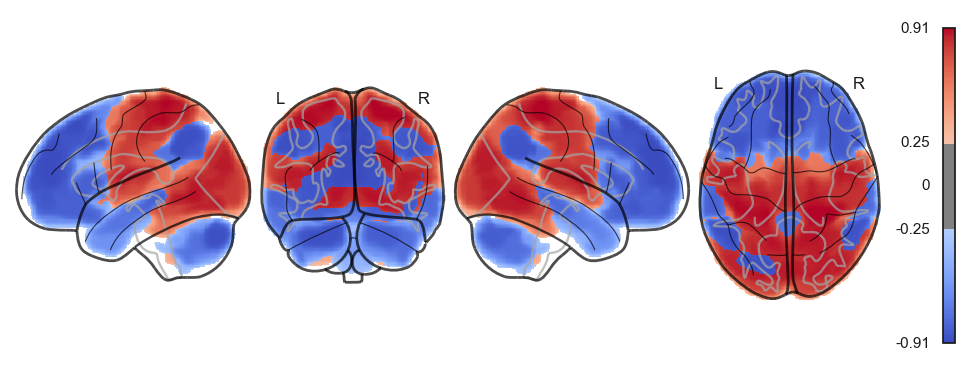

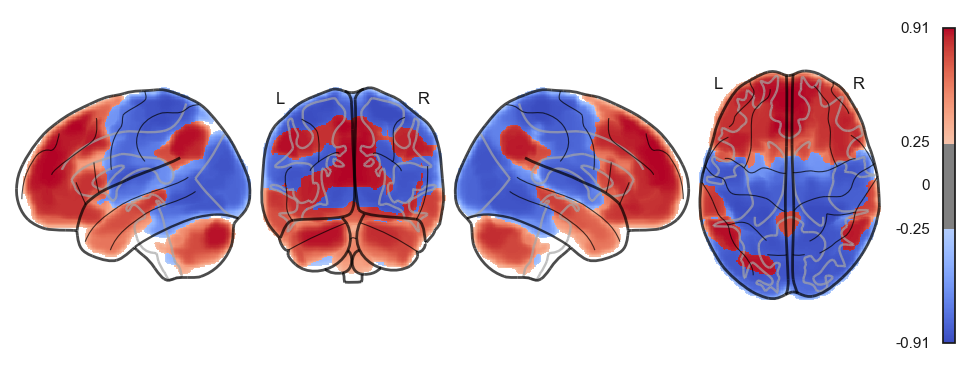

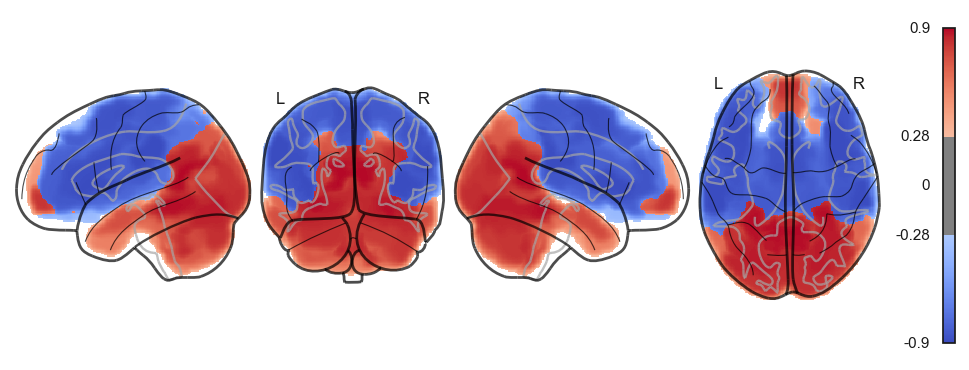

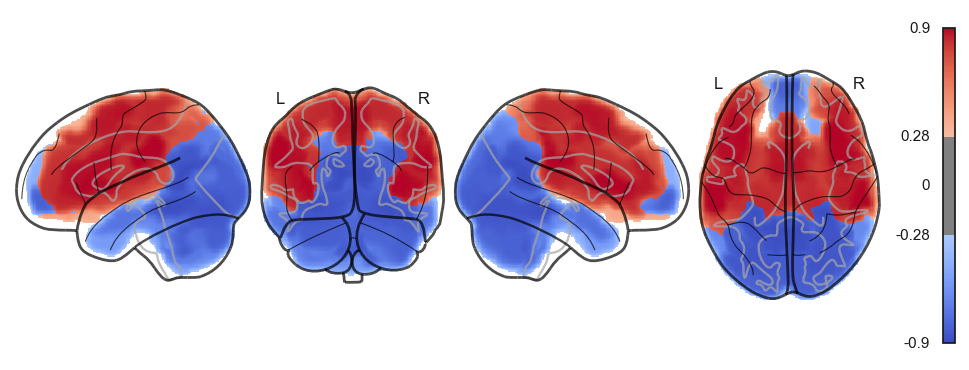

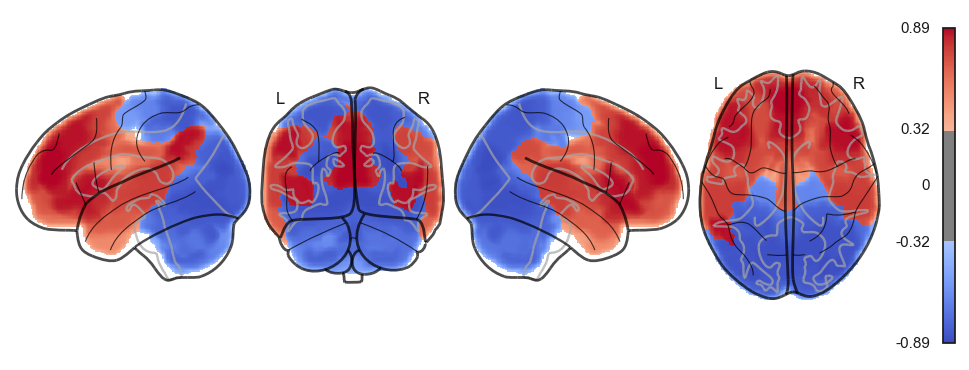

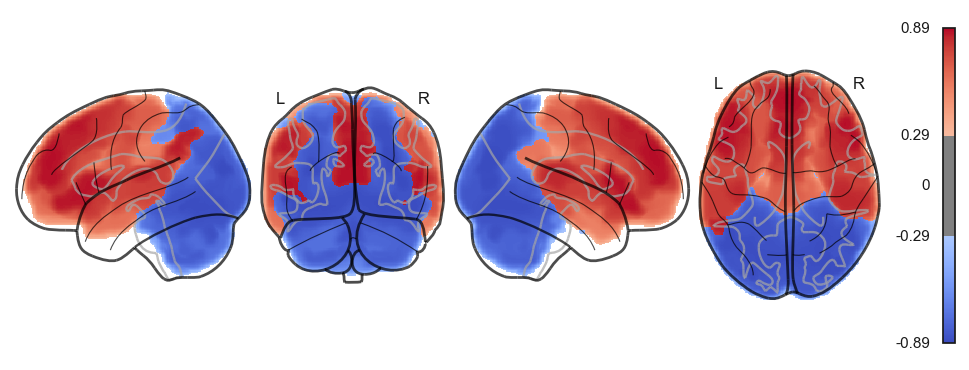

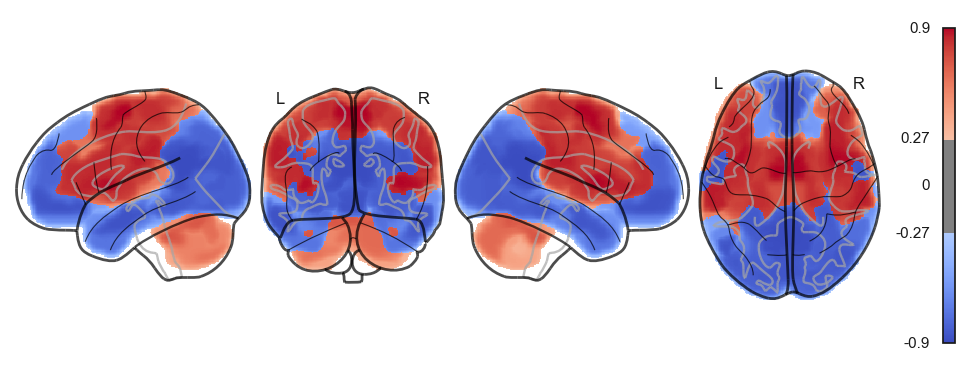

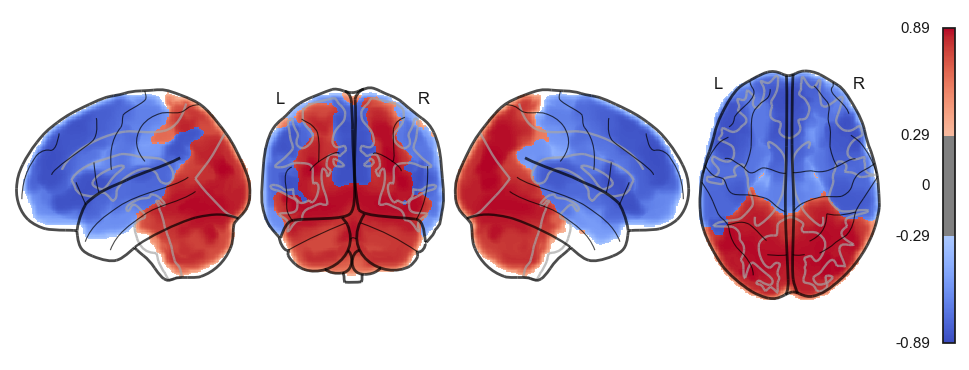

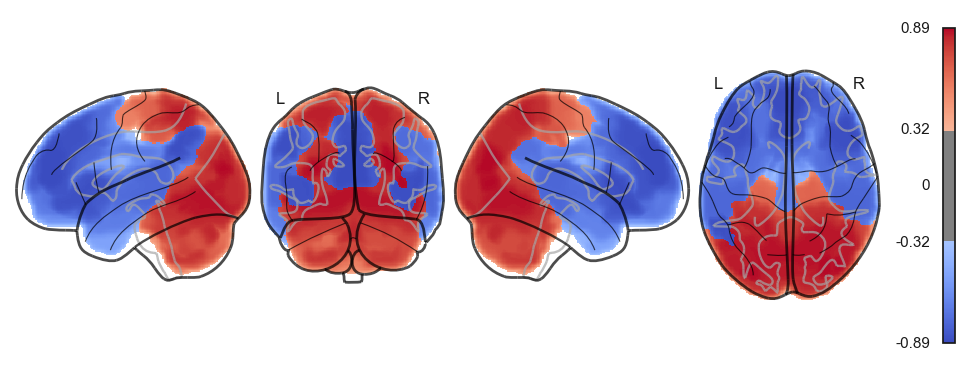

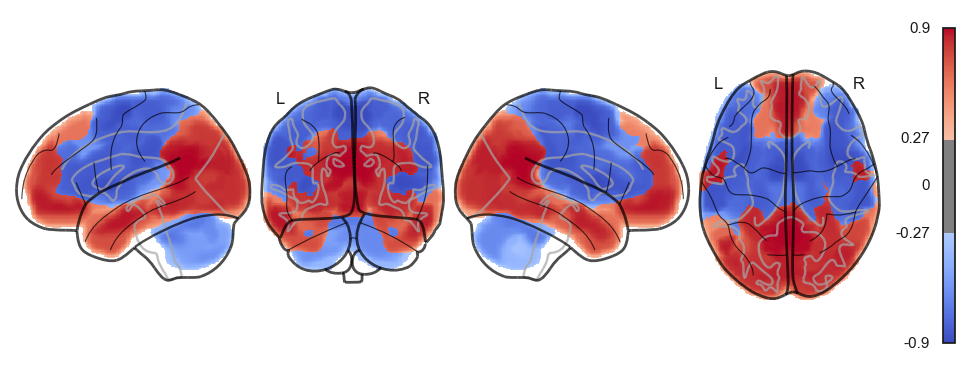

In [13]:
attractor_states_fchnn = np.array([k for i, (k, v) in enumerate(attractors_fchnn)])
for i in range(attractor_states_fchnn.shape[0]):
    network.State(attractor_states_fchnn[i]).plot()

## Attractor frequencies

In [15]:
for i, (k, v) in enumerate(attractors_fchnn):
    print(i, v)

0 27
1 23
2 20
3 11
4 5
5 4
6 4
7 2
8 2
9 2


## Reconstructing attractors: analytical approach

In [16]:
# comopute the negative precision matrix via nilearn
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='precision',  vectorize=False, discard_diagonal=False) # uses Ledoit-Wolf estimator
correlation_measure.fit_transform(all_ts)
J = -1 * correlation_measure.mean_

In [17]:
def compute_W_from_J(J, num_attractors=None):
    if num_attractors is None:
        num_attractors = J.shape[0]
    # Eigenvalue decomposition of J
    eigenvalues, eigenvectors = np.linalg.eigh(J)
    # Sort eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Select the first `num_hidden_nodes` eigenvalues and eigenvectors
    selected_eigenvalues = eigenvalues[:num_attractors]
    selected_eigenvectors = eigenvectors[:, :num_attractors]
    # Compute the weight matrix W
    W = selected_eigenvectors * np.sqrt(-selected_eigenvalues)
    return W

## Supplementary Analysis 1
### Computational vs. analytical attractor reconstruction

0


/Users/tspisak/src/ghost-in-the-machine/venv/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


1
2
3
4


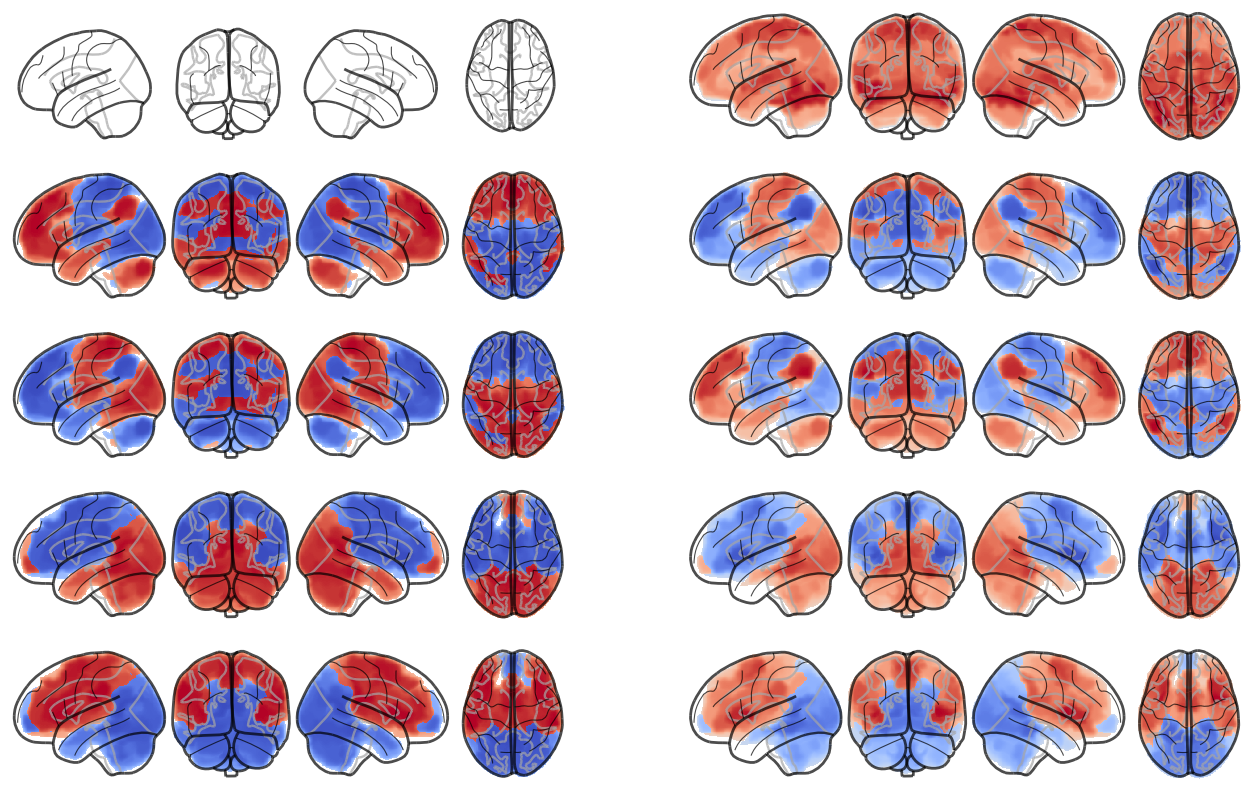

In [18]:
from connattractor import network

num_attractors = 5

# analytical solution
W = compute_W_from_J(J, num_attractors = num_attractors)

# fcHNN solution already stored in attractors_fchnn
# we change the order to match the analytical solution
attractor_states_fchnn = np.array([k for i, (k, v) in enumerate(attractors_fchnn)])
indices = [None, 1, 0, 2, 3]

fig, axs = plt.subplots(ncols=2, nrows=num_attractors, figsize=(16, 2*num_attractors))
for i in range(num_attractors):
    print(i)
    if i == 0:
        network.State(np.zeros(122)).plot(plot_abs=False, figure=fig, axes=axs[i, 0], annotate=False, colorbar=False)
        state_analytic = network.State(-1*W[:,i]) # *-1 for visualization
        state_analytic.plot(plot_abs=False, figure=fig, axes=axs[i, 1], annotate=False, colorbar=False)
    else:
        network.State(attractor_states_fchnn[indices[i]]).plot(plot_abs=False, figure=fig, axes=axs[i, 0], annotate=False, colorbar=False)
        if i % 2 == 0:
            state_analytic = network.State(W[:,int((i+1)/2)]) # original
            state_analytic.plot(plot_abs=False, figure=fig, axes=axs[i, 1], annotate=False, colorbar=False)
        else:
            state_analytic = network.State(-1*W[:,int((i+1)/2)]) # inverse
            state_analytic.plot(plot_abs=False, figure=fig, axes=axs[i, 1], annotate=False, colorbar=False)
plt.show()

0


/Users/tspisak/src/ghost-in-the-machine/venv/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:522: RuntimeWarning: invalid value encountered in divide
  data_copy /= (vmax - vmin)


1
2
3
4


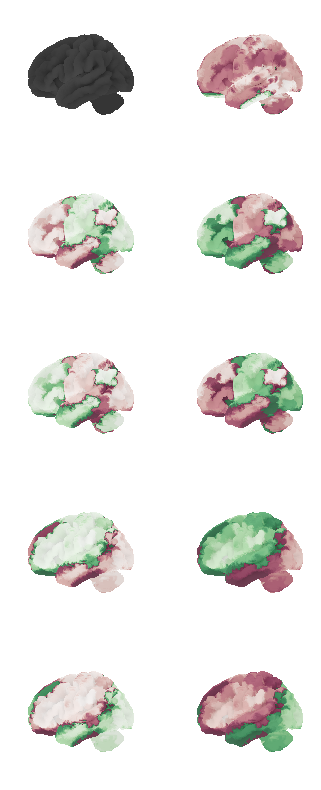

In [19]:
#| label: attractors
from connattractor import network

num_attractors = 5

from nilearn import surface, plotting, datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                    np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)

# analytical solution
W = compute_W_from_J(J, num_attractors = num_attractors)

# fcHNN solution already stored in attractors_fchnn
# we change the order to match the analytical solution
attractor_states_fchnn = np.array([k for i, (k, v) in enumerate(attractors_fchnn)])
indices = [None, 1, 0, 2, 3]

fig, axs = plt.subplots(ncols=2, nrows=num_attractors, figsize=(4, 2*num_attractors), subplot_kw={'projection': '3d'})
for i in range(num_attractors):
    print(i)
    if i == 0:
        network.State(np.ones(122)).plot(plot_abs=False, figure=fig, axes=axs[i, 0], annotate=False, colorbar=False)
        
        texture = np.zeros(surf.coordinates.shape[0])
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='purple_green_r', threshold=0, figure=fig, axes=axs[i, 0])
        
        img = network.State(-1*W[:,i]).to_Nifti1Image()
        texture = surface.vol_to_surf(img, surf)
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='purple_green_r', threshold=0, figure=fig, axes=axs[i, 1])
        
    else:
        img = network.State(attractor_states_fchnn[indices[i]]).to_Nifti1Image()
        texture = surface.vol_to_surf(img, surf)
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='purple_green_r', threshold=0, figure=fig, axes=axs[i, 0])
        
        if i % 2 == 0:
            img = network.State(W[:,int((i+1)/2)]).to_Nifti1Image()
            texture = surface.vol_to_surf(img, surf)
            fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='purple_green_r', threshold=0, figure=fig, axes=axs[i, 1])
        else:
            
            img = network.State(-1*W[:,int((i+1)/2)]).to_Nifti1Image()
            texture = surface.vol_to_surf(img, surf)
            fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='purple_green_r', threshold=0, figure=fig, axes=axs[i, 1])
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13


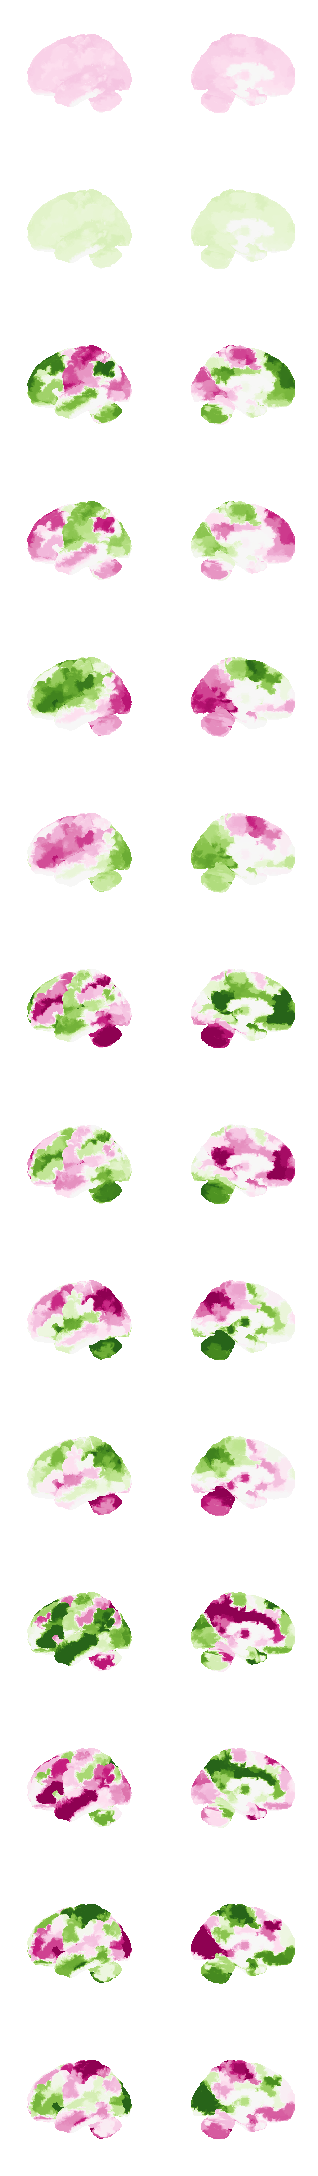

In [20]:
#| label: attractors
from connattractor import network

num_attractors = 14

from nilearn import surface, plotting, datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                    np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)

# analytical solution
W = compute_W_from_J(J, num_attractors = num_attractors)

# fcHNN solution already stored in attractors_fchnn
# we change the order to match the analytical solution
attractor_states_fchnn = np.array([k for i, (k, v) in enumerate(attractors_fchnn)])

fig, axs = plt.subplots(ncols=2, nrows=num_attractors, figsize=(4, 2*num_attractors), subplot_kw={'projection': '3d'})

for i in range(0,num_attractors):
    print(i)
        
    # cmap: PiYG, cyan_orange, cold_hot, blue_red
        
    if i % 2 == 0:
        img = network.State(W[:,int((i)/2)]).to_Nifti1Image()
        img.to_filename(f'data/attractor_{int((i)/2)}_pos.nii.gz')
        texture = surface.vol_to_surf(img, surf)
        #texture[texture<0] = 0
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=False, hemi='left', colorbar=False, cmap='PiYG', threshold=0, figure=fig, axes=axs[i, 0], symmetric_cbar=True, vmin=-0.2, vmax=0.2, darkness=1)
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=False, hemi='right', colorbar=False, cmap='PiYG', threshold=0, figure=fig, axes=axs[i, 1], symmetric_cbar=True, vmin=-0.2, vmax=0.2, darkness=1)
    else:
        img = network.State(-1*W[:,int((i)/2)]).to_Nifti1Image()
        img.to_filename(f'data/attractor_{int((i)/2)}_neg.nii.gz')
        texture = surface.vol_to_surf(img, surf)
        #texture[texture<0] = 0
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=False, hemi='left', colorbar=False, cmap='PiYG', threshold=0, figure=fig, axes=axs[i, 0], symmetric_cbar=True, vmin=-0.25, vmax=0.25, darkness=1)
        fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=False, hemi='right', colorbar=False, cmap='PiYG', threshold=0, figure=fig, axes=axs[i, 1], symmetric_cbar=True, vmin=-0.25, vmax=0.25, darkness=1)
plt.show()

/Users/tspisak/src/ghost-in-the-machine/venv/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:522: RuntimeWarning: invalid value encountered in divide
  data_copy /= (vmax - vmin)


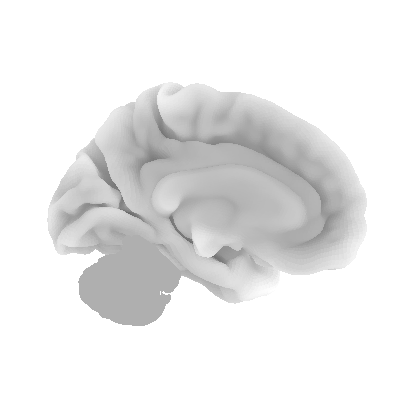

In [21]:
    from nilearn import surface, plotting, datasets
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
    surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
    bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                        np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)
    # plot control signal
    signal = np.zeros(122)
    img = network.State(signal).to_Nifti1Image()
    # due to numerical instabilities, the sign may flips, we flip ti back by np.sign(W[0,i])
    texture = surface.vol_to_surf(img, surf)
    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='right', colorbar=False, cmap='coolwarm', threshold=0.2)

In [22]:
mist_regions = pd.read_csv('data/MIST122_relabeled.tsv', sep='\t')
mist_regions.columns = ['label', 'MIST_index', 'region', 'module']
mist_mapper=mist_regions[['label', 'region']]
mist_mapper.set_index('region', inplace=True)
mist_mapper.loc['CER6_p', 'label']
mist_regions

label  MIST_index      region  module
0        1           9      CER6_p     CER
1        2         108      CER7ab     CER
2        3         121  R_CERCR2_p     CER
3        4          14      CER9_v     CER
4        5          97      CER6_a     CER
..     ...         ...         ...     ...
117    118         107  PVISnet_vm  VISnet
118    119          19  MVISnet_ad  VISnet
119    120         101   VVISnet_l  VISnet
120    121          43  LVISnet_DP  VISnet
121    122          40   VVISnet_m  VISnet

[122 rows x 4 columns]

In [23]:
# top 5 positive and negative weights for all attractors
num_attractors = 6
W = compute_W_from_J(J, num_attractors=num_attractors)
for i in range(num_attractors):
    print(f'Attractor {i}')
    print('Positive weights:')
    positive_indices = np.argsort(W[:, i])[::-1][:10]
    for idx in positive_indices:
        region = mist_mapper.loc[mist_mapper['label'] == idx+1].index[0]
        weight = W[idx, i]
        print(f'{region}: {weight}')
    
    print('Negative weights:')
    negative_indices = np.argsort(W[:, i])[:10]
    for idx in negative_indices:
        region = mist_mapper.loc[mist_mapper['label'] == idx+1].index[0]
        weight = W[idx, i]
        print(f'{region}: {weight}')

Attractor 0
Positive weights:
CER9_v: -0.0045697193688509306
CER7b_l: -0.022564042103674336
CER9_m: -0.0312400511652437
MORBgyr: -0.03264382343688
THAL_v: -0.03621428305872353
CAUDNH_NACC: -0.03677707806347359
CAUDN_d: -0.037117304494786785
CER7b_m: -0.03756792513887191
CER9_d: -0.037712575290940104
CAUDN_v: -0.037930088566299085
Negative weights:
PRC_d: -0.06655287573521601
LVISnet_vp: -0.06592787799143819
OCCTgyr_l: -0.06532554393387485
CERCR1: -0.0650805892064828
MOTnet_ml: -0.06317555094693857
STgyr_m: -0.06301544117943406
SPlob: -0.062067892962386274
PCsul_d: -0.06143755242764257
PSMcor_a: -0.061400506131860884
VVISnet_m: -0.06098846893881961
Attractor 1
Positive weights:
L_IPlob: 0.207443569634894
SFgyr_ad: 0.1982101873091965
L_IPlob: 0.19433560394902077
R_IPlob: 0.19174560534645765
DMPFC_ar: 0.18978511193580166
DMPFcor_ac: 0.1834258204528352
L_MFgyr_pr: 0.17644985781128353
L_SFsul_a: 0.1741972762352281
PCcor: 0.15692587366533337
L_CERCR2_p: 0.15342217806687064
Negative weights:


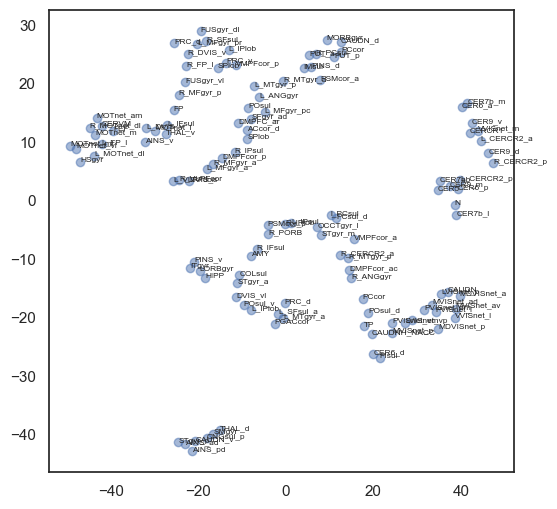

In [24]:
W = compute_W_from_J(J, num_attractors=12)
# do tsne on the weights
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
W_tsne = tsne.fit_transform(W)
#plot it
plt.figure(figsize=(6,6))
plt.scatter(W_tsne[:,0], W_tsne[:,1], alpha=0.5)
# add labels
for i, txt in enumerate(range(1, len(W_tsne))):
    plt.annotate(mist_regions.iloc[i-1, 2], (W_tsne[i,0], W_tsne[i,1]), fontsize=6)
plt.show()

In [25]:
attractor_states_fchnn.shape

(10, 122)

In [31]:
def hn_energy(state, threshold):
    return  -0.5 * state @ J @ state + state @ threshold

def plot_manifold(num_attractors = 6, perplexity=None, smooth_sigma=0.8, filename=None):

    from openTSNE import TSNE
    W = compute_W_from_J(J, num_attractors=num_attractors)

    if perplexity is None:
        perplexity = (num_attractors+1)/3

    W_paired = []
    for i in range(0, num_attractors):
        W_paired.append(W[:,i])
        W_paired.append(-W[:,i])
    W_paired = np.array(W_paired).T
    
    #W_paired = attractor_states_fchnn.T
    
    # do tsne on the weights
    tsne = TSNE(n_components=2, perplexity=perplexity, initialization='pca', metric="euclidean", random_state=42, n_jobs=16)
    tsne_embedding = tsne.fit(W_paired.transpose())
    W_tsne = tsne_embedding[:num_attractors*2,:]
    W_paired = W_paired[:,:num_attractors*2]
    #transform sample
    sample = np.vstack(all_ts)
    sample_tsne = tsne_embedding.transform(sample, perplexity=perplexity)

    from scipy.stats import binned_statistic_2d
    energies = np.array([hn_energy(sample[i], np.zeros(J.shape[0])) for i in range(sample.shape[0])])
    mean_energy = binned_statistic_2d(sample_tsne[:,0], sample_tsne[:,1], values=energies, statistic='mean', bins=20)
    # smooth ean_energy.statistic
    from scipy.ndimage import gaussian_filter
    mean_energy_smoothed = np.copy(mean_energy.statistic)
    grand_mean = np.mean(mean_energy_smoothed[~ np.isnan(mean_energy_smoothed)])
    mean_energy_smoothed[np.isnan(mean_energy_smoothed)] = grand_mean  # mean inputting
    mean_energy_smoothed = gaussian_filter(mean_energy_smoothed, sigma=smooth_sigma)
    mean_energy_smoothed_nan = mean_energy_smoothed.copy()
    mean_energy_smoothed_nan[np.isnan(mean_energy.statistic)] = np.nan  # write back nan values
    # plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    attractor_energies = [hn_energy(W_paired[:,i], np.zeros(J.shape[0])) for i in range(W_paired.shape[1])]
    
    ##########
    sctplt = axes[0].scatter(sample_tsne[:,0], sample_tsne[:,1], alpha=0.5, c=[hn_energy(sample[i], np.zeros(J.shape[0])) for i in range(sample.shape[0])],cmap='coolwarm', s=6, vmin=100, vmax=350, edgecolor='none')
    plt.colorbar(sctplt,ax=axes[0], location='bottom', shrink=0.6, ticks=[100, 350])
    axes[0].scatter(W_tsne[:,0], W_tsne[:,1], alpha=0.5, c=attractor_energies,cmap='coolwarm', s=30, edgecolors= "black", vmin=100, vmax=350)
    ##########
    
    sns.kdeplot(x=sample_tsne[:,0], y=sample_tsne[:,1], ax=axes[1], cmap='Greens', cbar=True, fill=True, levels=8, thresh=0.01, alpha=1.0,antialiased=True, cbar_kws={"location":"bottom", "shrink":0.6, "ticks":[0.01, 0.1]})
    axes[1].scatter(W_tsne[:,0], W_tsne[:,1], alpha=0.5, c=attractor_energies,
    cmap='coolwarm', edgecolors= "black", vmin=200, vmax=280, color=None)
    
    ###########
    implt = axes[2].imshow(mean_energy_smoothed_nan.transpose(), origin='lower', extent=(sample_tsne[:,0].min(), sample_tsne[:,0].max(), sample_tsne[:,1].min(), sample_tsne[:,1].max()), aspect='auto', cmap='coolwarm', vmin=200, vmax=280,
               #interpolation='bicubic'
               )
    plt.colorbar(implt,ax=axes[2], location='bottom', shrink=0.6, ticks=[200, 280])
    axes[2].scatter(W_tsne[:,0], W_tsne[:,1], alpha=0.5, c=attractor_energies,
    cmap='coolwarm', edgecolors= "black", vmin=200, vmax=280, s=30)
    # set limits
    axes[2].set_xlim(sample_tsne[:,0].min()*1.1, sample_tsne[:,0].max()*1.1)
    axes[2].set_ylim(sample_tsne[:,1].min()*1.1, sample_tsne[:,1].max()*1.1)
    
    
    for i, txt in enumerate(range(0, W_tsne.shape[0])):
        axes[0].annotate(txt, (W_tsne[i,0], W_tsne[i,1]))
        axes[1].annotate(txt, (W_tsne[i,0], W_tsne[i,1]))
        axes[2].annotate(txt, (W_tsne[i,0], W_tsne[i,1]))
    
    sns.despine() #left=True, bottom=True)
    
    ## Surface plot:
    # swap 4th subplot to 3d
    axes[3].remove()
    axes[3] = fig.add_subplot(1, 4, 4, projection='3d')

    # Extracting the necessary information
    mean_values = mean_energy_smoothed  # The mean energy in each bin
    x_edges = mean_energy.x_edge         # The edges of the bins in the x direction
    y_edges = mean_energy.y_edge         # The edges of the bins in the y direction
    
    # Calculate bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # Create a meshgrid for the surface plot
    X, Y = np.meshgrid(x_centers, y_centers)
    
    # Plotting the 3D surface    
    # Surface plot
    for i in range(0, W_tsne.shape[0]):
        # search closes point from the meshgrid
        x_idx = np.argmin(np.abs(x_centers - W_tsne[i,0]))
        y_idx = np.argmin(np.abs(y_centers - W_tsne[i,1]))
        #ax.scatter(x_centers[x_idx], y_centers[y_idx], mean_values[x_idx, y_idx], color='black', s=30)
        axes[3].plot([x_centers[x_idx], x_centers[x_idx]],
                [y_centers[y_idx],y_centers[y_idx]],
                zs=[mean_values[x_idx, y_idx]+2, mean_values[x_idx, y_idx]+20], color='black')
    
    surf = axes[3].plot_surface(X, Y, mean_values.T, cmap='coolwarm', linewidth=0.1)
    
    axes[3].set_zlim(200, 280)
    axes[3].view_init(elev=50, azim=-70)
    # zoom in a bit more
    #axes[3].dist = 3
    
    zoom = 0.8
    axes[3].set_xlim3d(sample_tsne[:,0].min()*zoom, sample_tsne[:,0].max()*zoom)
    axes[3].set_ylim3d(sample_tsne[:,0].min()*zoom, sample_tsne[:,0].max()*zoom)
    axes[3].set_zlim3d(100, 350)     
    # remove axes and everything
    axes[3].set_axis_off()
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    

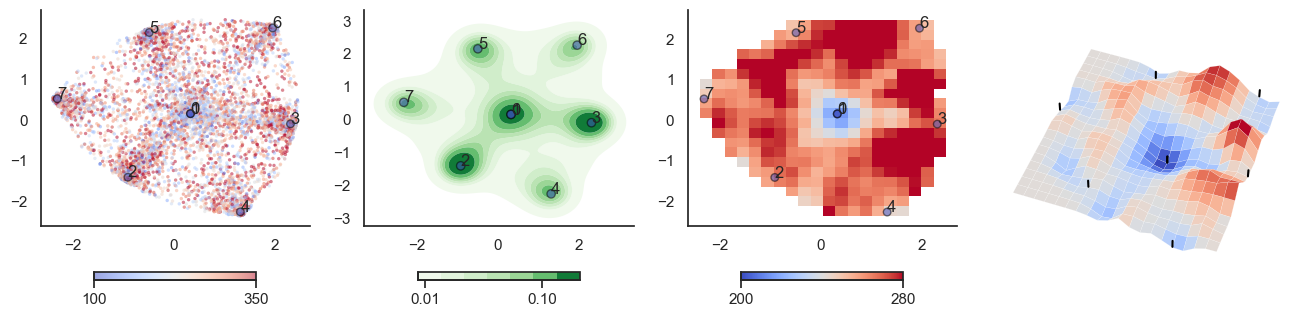

In [32]:
plot_manifold(num_attractors = 4)

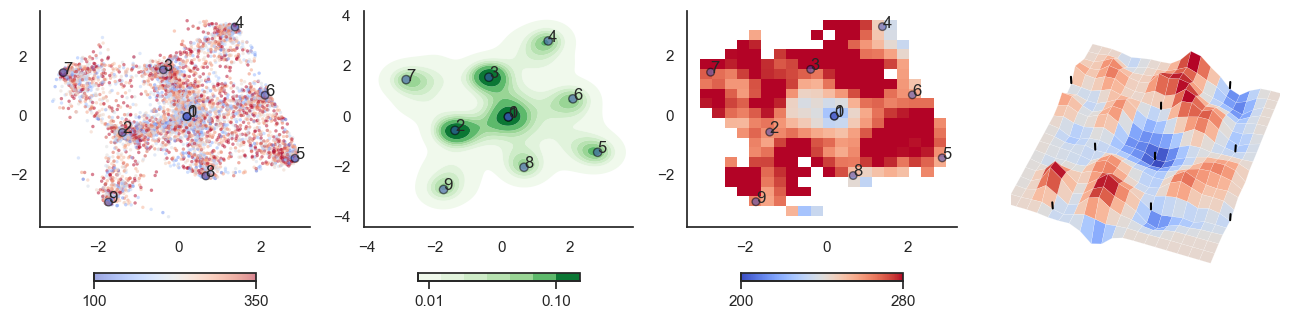

In [33]:
plot_manifold(num_attractors = 5)

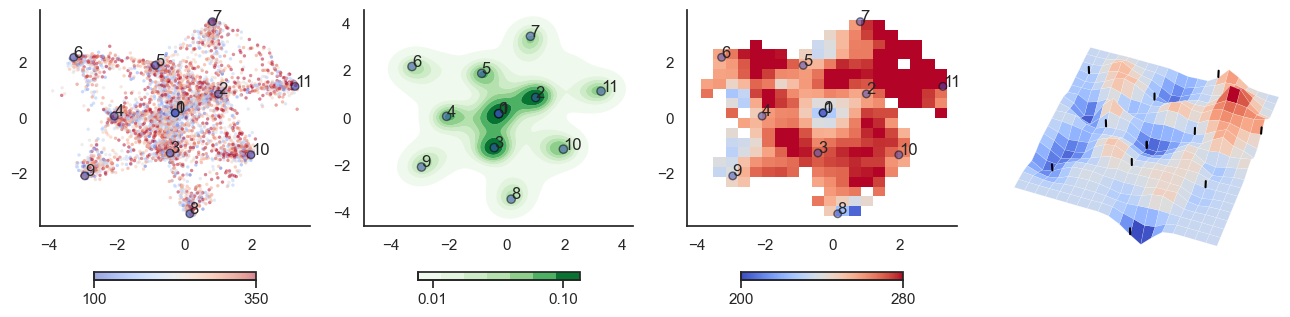

In [34]:
plot_manifold(num_attractors = 6, filename='fig/attractor_manifold.pdf')

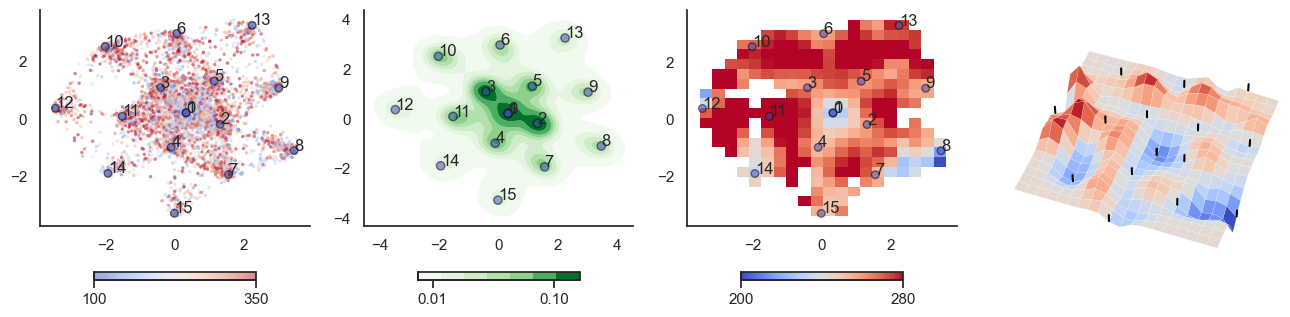

In [35]:
plot_manifold(num_attractors = 8)

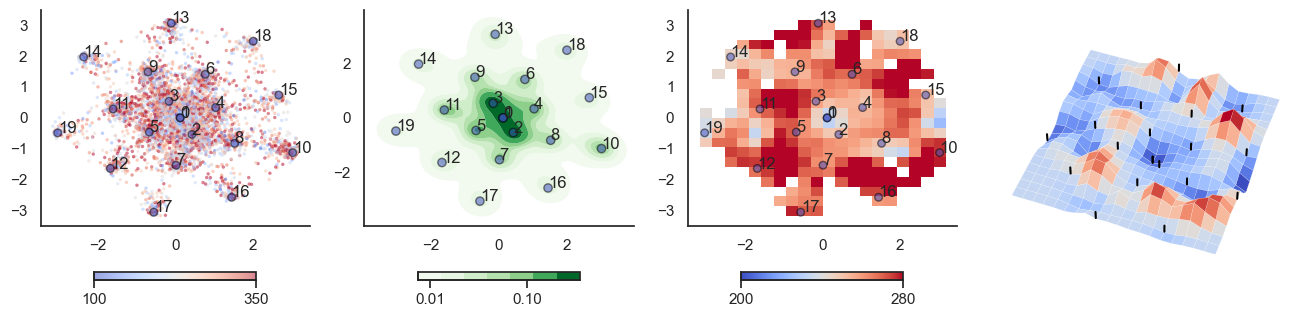

In [36]:
plot_manifold(num_attractors = 10)

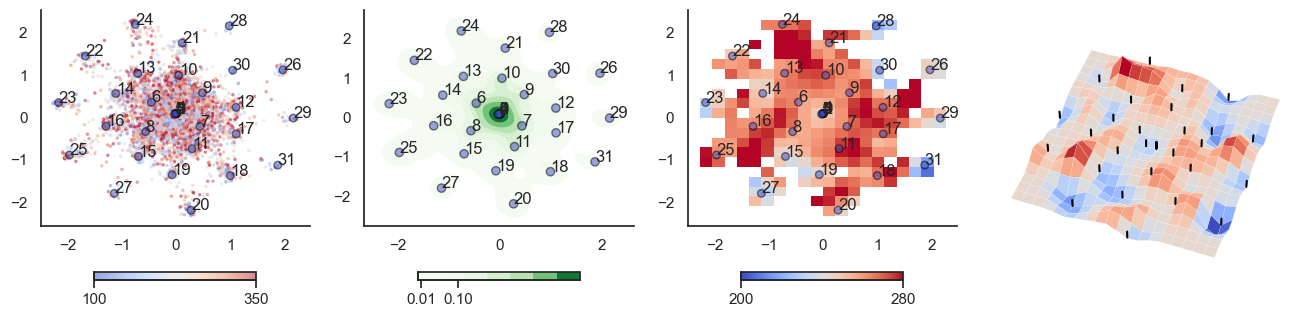

In [37]:
plot_manifold(num_attractors = 16)

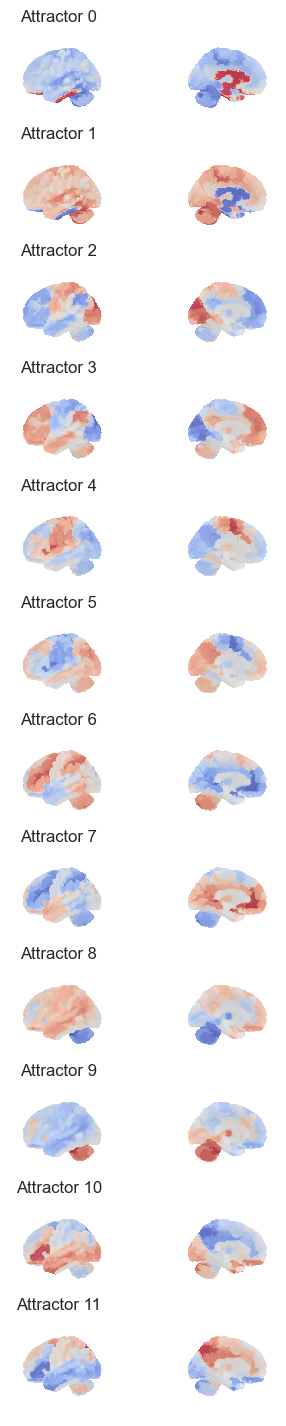

In [ ]:
from connattractor import network
from nilearn import surface, plotting, datasets

fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                        np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)

W = compute_W_from_J(J, num_attractors=num_attractors)

num_attractors = 6

W_paired = []
for i in range(0, num_attractors):
     W_paired.append(W[:,i])
     W_paired.append(-W[:,i])
W_paired = np.array(W_paired).T

fig, axes = plt.subplots(nrows=num_attractors*2, ncols=2, figsize=(4, 3*num_attractors), subplot_kw={'projection': '3d'})

for i in range(num_attractors*2):
    img = network.State(W_paired[:,i]).to_Nifti1Image()
    texture = surface.vol_to_surf(img, surf)
    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='coolwarm', threshold=0, figure=fig, axes=axes[i, 0], title='Attractor {}'.format(i))
    
    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='right', colorbar=False, cmap='coolwarm', threshold=0, figure=fig, axes=axes[i, 1])
    
#plt.savefig('fig/attractor_states.pdf')
    
plt.show()

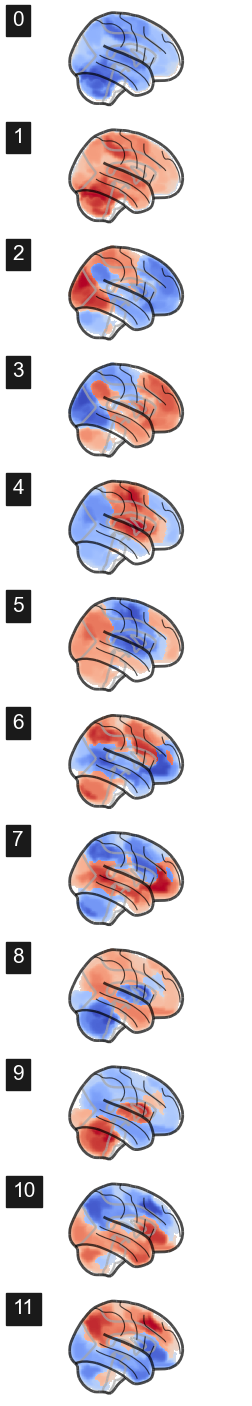

In [ ]:
from connattractor import network
from nilearn import surface, plotting, datasets

fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                        np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)

W = compute_W_from_J(J, num_attractors=num_attractors)

num_attractors = 6

W_paired = []
for i in range(0, num_attractors):
     W_paired.append(W[:,i])
     W_paired.append(-W[:,i])
W_paired = np.array(W_paired).T

fig, axes = plt.subplots(nrows=num_attractors*2, ncols=1, figsize=(3, 3*num_attractors))

for i in range(num_attractors*2):
    network.State(W_paired[:,i]).plot(display_mode='x', plot_abs=False, figure=fig, axes=axes[i],
                                      title=str(i), annotate=False, colorbar=False)
#plt.savefig('fig/attractor_states.pdf')
    
plt.show()




In [ ]:
from connattractor import network
# fcHNN solution
correlation_measure = ConnectivityMeasure(kind='partial correlation',  vectorize=False, discard_diagonal=False) # uses Ledoit-Wolf estimator
correlation_measure.fit_transform(all_ts)
parcor = 1 * correlation_measure.mean_
hopnet = network.Hopfield(parcor)
hopnet.W = (parcor-np.mean(parcor))/np.std(parcor) # overwrite the weights to put back the diagonal
attractors = {}
rng = np.random.default_rng(42)
for i in range(1000):
    res = hopnet.update(np.tanh(rng.normal(0,1,122)), threshold=0, beta=0.055, num_iter=10000)
    if res[1]<10000: # converged
        state = tuple(np.round(res[0], 6))
        if state not in attractors.keys():
            attractors[state] = 1
        else:
            attractors[state] += 1

attractors_fchnn = sorted(attractors.items(), key=lambda item: item[1])[::-1]
len(attractors_fchnn)

4

In [ ]:
def_control_signals = [1, 2, 1000] #np.logspace(-0.5,0.5,5)

def control_signal_analysis(conrol_sigmal_index, control_signals = def_control_signals, num_attractors = 5):
    
    W_null = compute_W_from_J(J, num_attractors = num_attractors)
    
    from nilearn import surface, plotting, datasets
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
    surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
    bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                        np.zeros(28935))) # magic number: number of cerebellum vertices (SUIT cerebellum template)
    # plot control signal
    signal = np.zeros(122)
    print(conrol_sigmal_index)
    for idx in conrol_sigmal_index:
        signal[idx-1] = 1
    img = network.State(signal).to_Nifti1Image()
    # due to numerical instabilities, the sign may flips, we flip ti back by np.sign(W[0,i])
    texture = surface.vol_to_surf(img, surf)
    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='coolwarm', threshold=0.2)
    
    fig, axs = plt.subplots(ncols=len(control_signals), nrows=num_attractors, figsize=(len(control_signals)*2, 2*num_attractors), subplot_kw={'projection': '3d'})
    for i in range(num_attractors):
        
        for j, control_signal in enumerate(control_signals):
            
            J_stim = np.copy(J)
            for idx in conrol_sigmal_index:
                J_stim[idx,idx] *= control_signal 
            W = compute_W_from_J(J_stim, num_attractors = num_attractors)
            
            if i == 0: # eigencentrality
                signflip = -1*np.sign(np.corrcoef(W_null[:,i], W[:,i])[0,1])
                img = network.State(signflip*W[:,i]).to_Nifti1Image()
                # due to numerical instabilities, the sign may flips, we flip ti back by np.sign(W[0,i])
                texture = surface.vol_to_surf(img, surf)
                fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='coolwarm', threshold=0, figure=fig, axes=axs[i, j])
                
            else:  
                signflip = np.sign(np.corrcoef(W_null[:,int((i+1)/2)], W[:,int((i+1)/2)])[0,1])
                if i % 2 == 0:
                    img = network.State(signflip*W[:,int((i+1)/2)]).to_Nifti1Image()
                    texture = surface.vol_to_surf(img, surf)
                    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='coolwarm', threshold=0, figure=fig, axes=axs[i, j])
                else:
                    img = network.State(-1*signflip*W[:,int((i+1)/2)]).to_Nifti1Image()
                    texture = surface.vol_to_surf(img, surf)
                    fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', colorbar=False, cmap='coolwarm', threshold=0, figure=fig, axes=axs[i, j])
    plt.show()


In [ ]:
mist_mapper.index.values
# see also: https://simexp.github.io/multiscale_dashboard/index.html

array(['CER6_p', 'CER7ab', 'R_CERCR2_p', 'CER9_v', 'CER6_a', 'L_CERCR2_a',
       'CER9_d', 'CER9_m', 'CER7b_m', 'L_CERCR2_p', 'CER7b_l', 'N',
       'CERCR1', 'CER6_d', 'CER5', 'R_CERCR2_a', 'POsul_d', 'POsul_v',
       'VMPFcor_p', 'R_MTgyr_a', 'L_ANGgyr', 'L_MTgyr_p', 'L_MTgyr_a',
       'DMPFC_ar', 'L_SFsul_a', 'DMPFcor_ac', 'PCcor', 'POsul', 'L_IPlob',
       'PGACcor', 'VMPFcor_a', 'PRC_d', 'SFgyr_ad', 'L_IPlob', 'R_ANGgyr',
       'PRC_v', 'R_MTgyr_p', 'PRC_d', 'R_MFgyr_a', 'L_DVIS_v', 'SPlob',
       'R_VLPFcor', 'FUSgyr_vl', 'R_IFsul', 'FP', 'R_DVIS_v', 'L_FP_l',
       'SPlob', 'L_MFgyr_pc', 'L_VLPFcor', 'OCCTgyr_l', 'ACcor_d',
       'L_MFgyr_pr', 'R_MFgyr_p', 'R_IPsul', 'L_IFsul', 'DVIS_s',
       'FUSgyr_dl', 'R_SFsul', 'R_IPlob', 'R_FP_l', 'R_PORB', 'DMPFcor_p',
       'L_IPsul', 'L_MFgyr_a', 'DVIS_vl', 'CAUDNH_NACC', 'COLsul',
       'LORBgyr', 'ITgyr', 'STgyr_a', 'MORBgyr', 'PINS_v', 'TP', 'HIPP',
       'AMY', 'PIsul', 'CERVM', 'L_MOTnet_dl', 'MOTnet_am', 'R_MOTnet_dl'

[76]


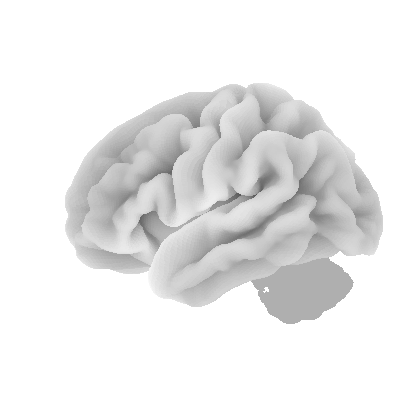

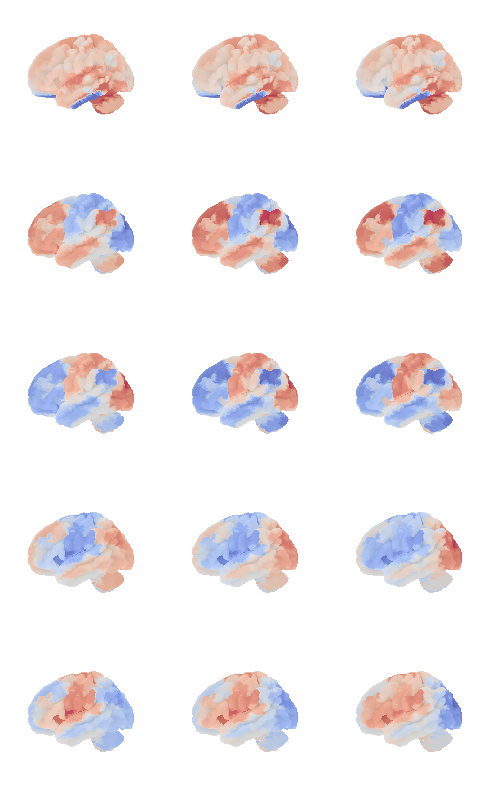

In [ ]:
control_signal_analysis(mist_mapper.loc[['AMY'], 'label'].values)

[50]


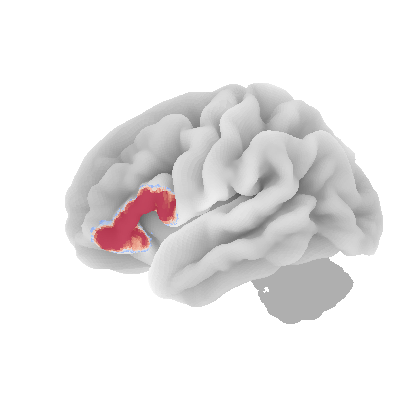

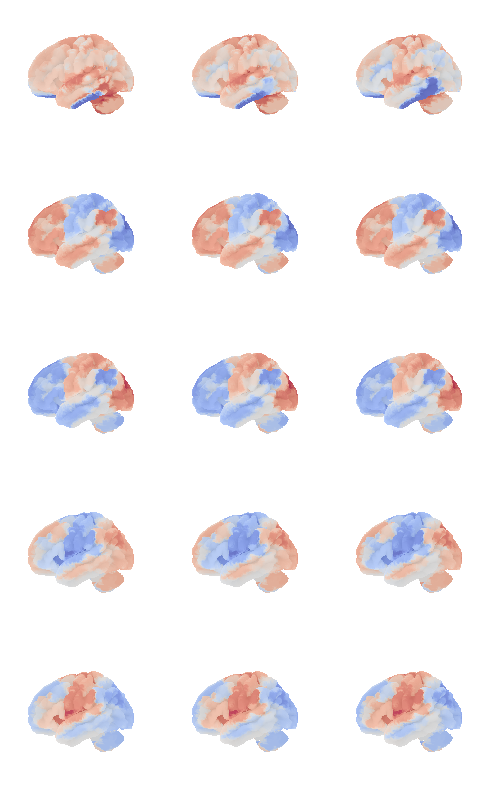

In [ ]:
control_signal_analysis(mist_mapper.loc[['L_VLPFcor'], 'label'].values)

[ 93  86 104]


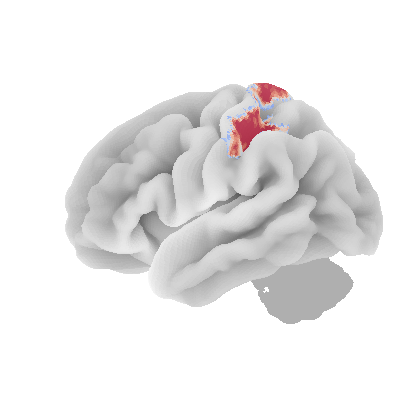

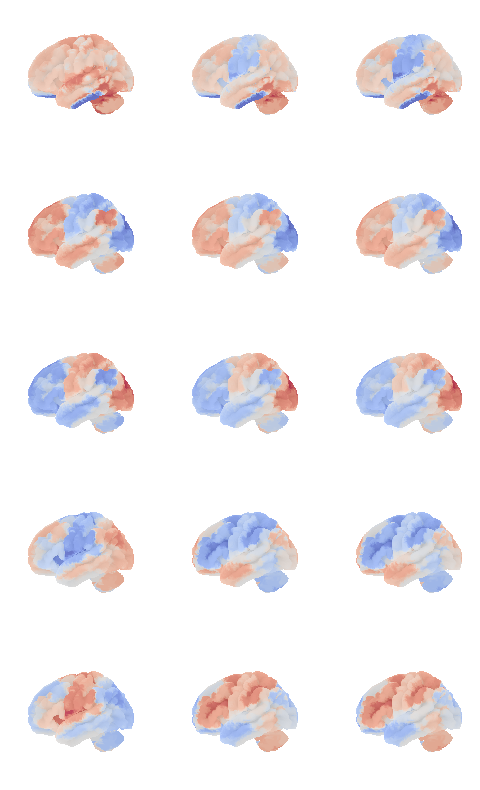

In [ ]:
control_signal_analysis(mist_mapper.loc[['PCsul_d', 'l_PCsul', 'R_PCsul'], 'label'].values)

[84]


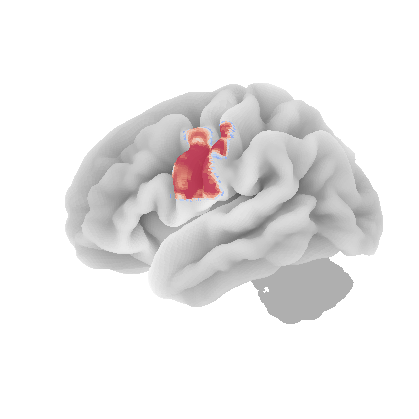

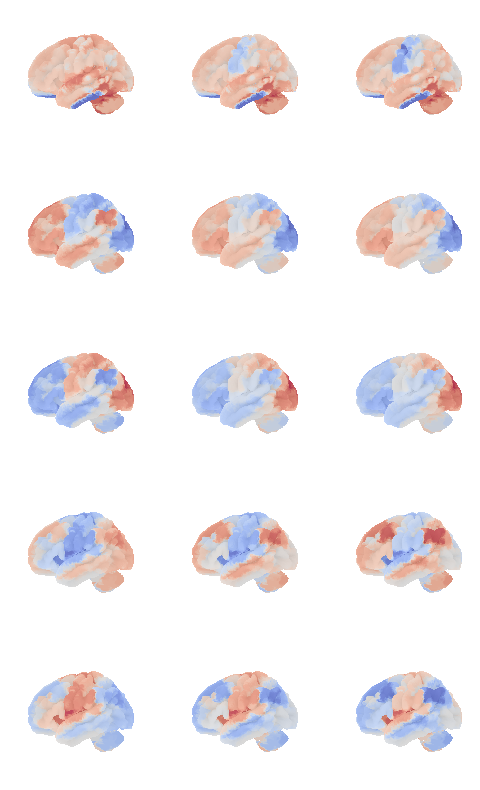

In [ ]:
control_signal_analysis(mist_mapper.loc[['MOTnet_vl'], 'label'].values)

[21]


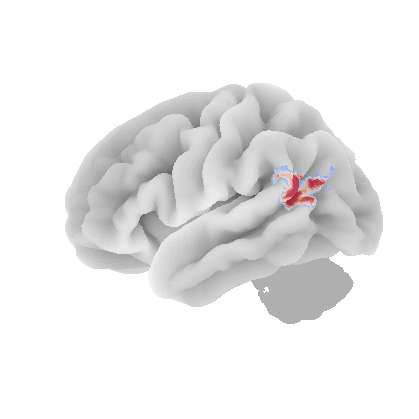

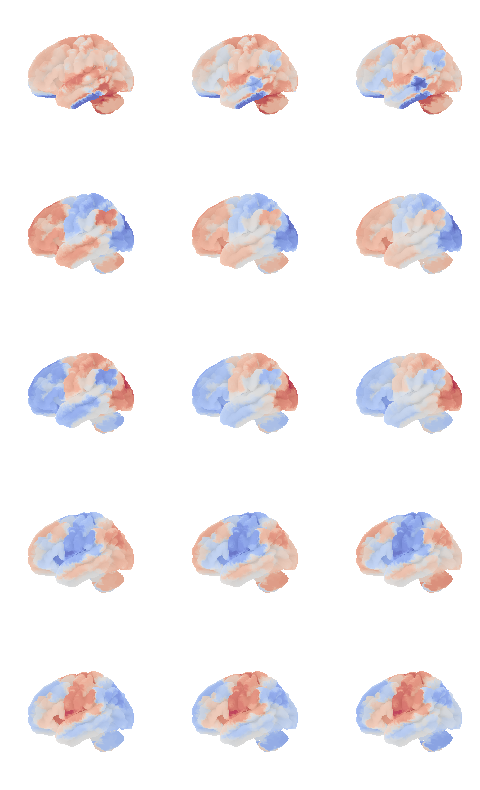

In [ ]:
control_signal_analysis(mist_mapper.loc[['L_ANGgyr'], 'label'].values)

[118]


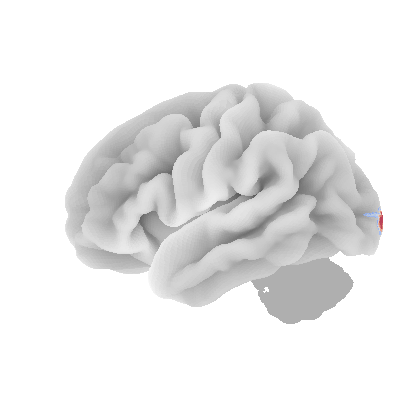

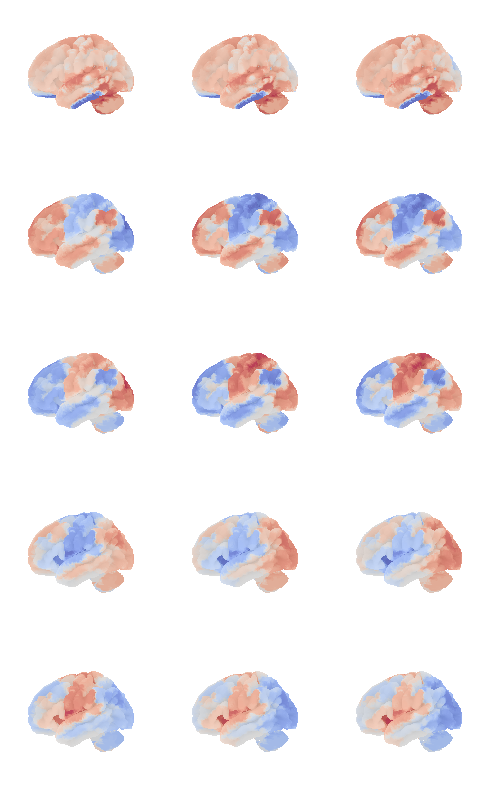

In [ ]:
control_signal_analysis(mist_mapper.loc[['PVISnet_vm'], 'label'].values)

[105]


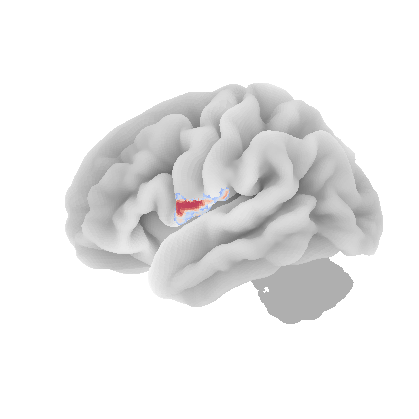

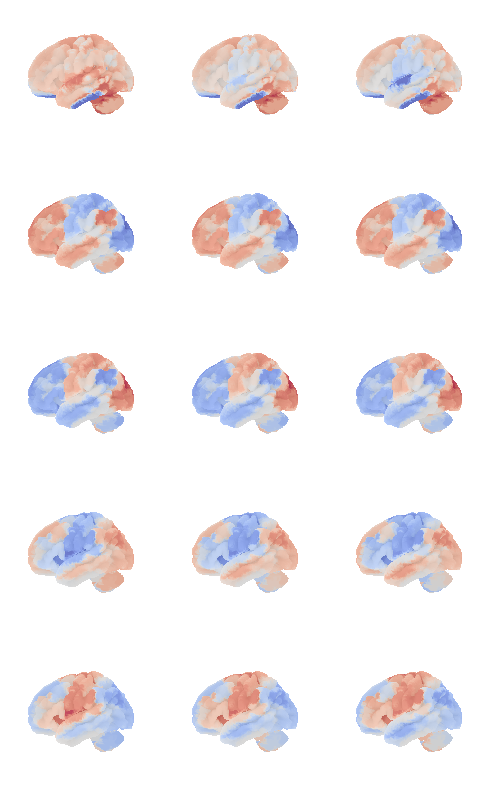

In [ ]:
control_signal_analysis(mist_mapper.loc[['PINS_d'], 'label'].values)

## Supplementary Information 11

Connections required for a restricted Boltzmann Machine (RBM) with the same number of (hidden) integrator nodes as stored by Hopfield networks with various storage capacities.

741


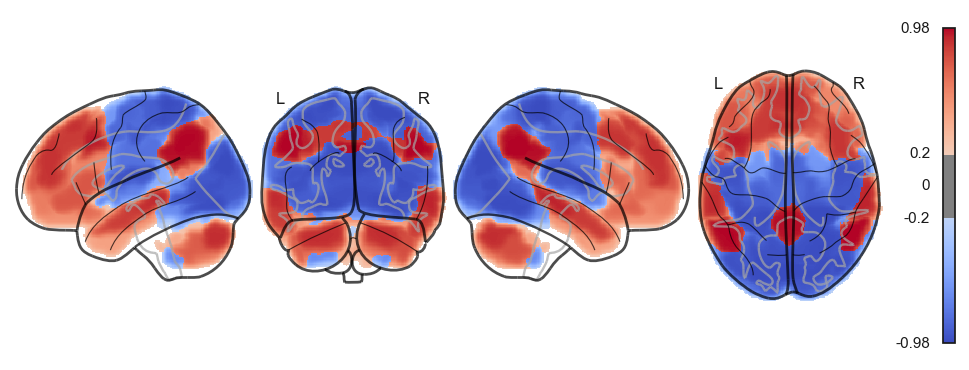

In [ ]:
correlation_measure = ConnectivityMeasure(kind='precision', vectorize=False, discard_diagonal=False) # uses Ledoit-Wolf estimator
M = correlation_measure.fit_transform(all_ts)
J = -1* correlation_measure.mean_
hopnet = network.Hopfield(J, scale=True)
res = hopnet.update(np.tanh(np.random.normal(0,1,122)), threshold=0, beta=0.06, num_iter=100000)
print(res[1])
network.State(res[0]).plot(plot_abs=False)

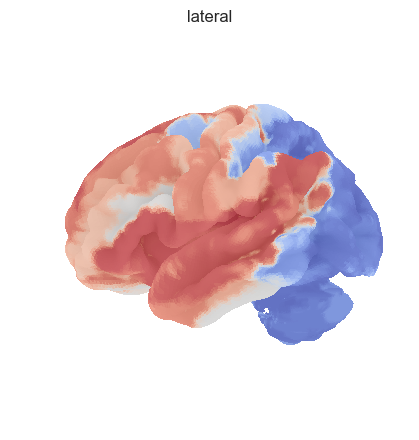

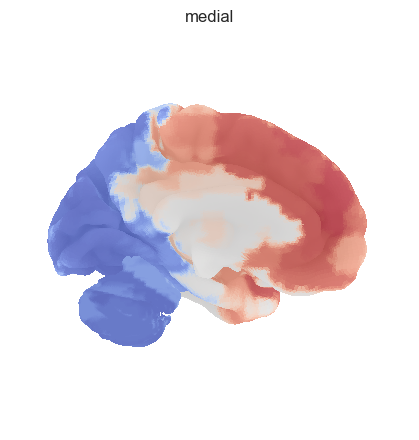

In [ ]:
from nilearn import surface, plotting, datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')
surf = surface.load_surf_mesh('data/full_brain_left.surf.gii')
bg_map = np.hstack((surface.load_surf_data(fsaverage.sulc_left),
                    np.zeros(28935)))

img = network.State(res[0]).to_Nifti1Image()
texture = surface.vol_to_surf(img, surf)
fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='left', title='lateral', colorbar=False, cmap='coolwarm', threshold=0)
fig = plotting.plot_surf_stat_map(surf, texture, bg_map=bg_map, bg_on_data=True, hemi='right', title='medial', colorbar=False, cmap='coolwarm', threshold=0)

In [ ]:
bg_map.shape, surf.coordinates.shape

((49419,), (110859, 3))

In [ ]:
plotting.plot_surf_stat_map(
        surf, texture, hemi='left',
        title='title', colorbar=True, cmap='coolwarm',
        threshold=0)#, bg_map=fsaverage.sulc_left)



In [ ]:
from nilearn.image import smooth_img
img = network.State(res[0]).to_Nifti1Image()
# plot surface
from nilearn import plotting
fig, axes = plotting.plot_img_on_surf(img, surf_mesh=s, threshold=0, inflate=False, 
                           cmap='coolwarm', bg_on_data=True, alpha=1)

ValueError: {'pial_left', 'sulc_left', 'pial_right', 'infl_left', 'sulc_right', 'infl_right'} are missing from the provided mesh dictionary

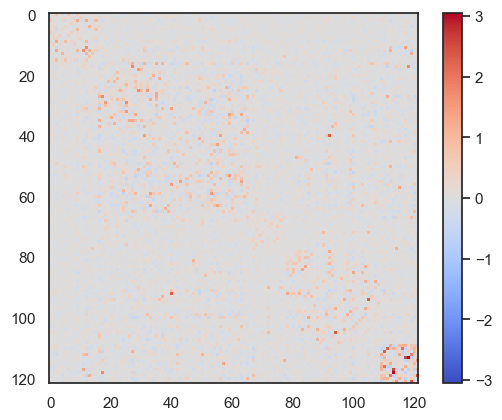

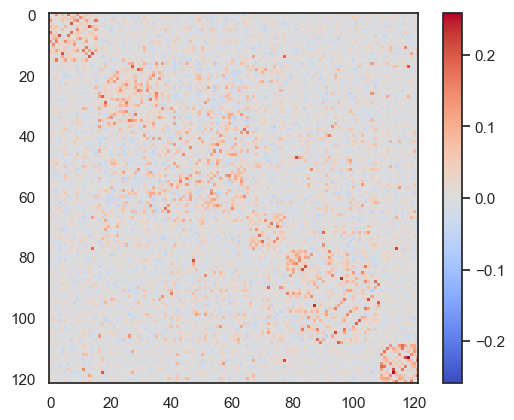

In [ ]:
network.Hopfield(J).plot_weights()
plt.show()
network.Hopfield(J2).plot_weights()

In [ ]:
def compute_W_from_J(J, num_attractors=None):
    if num_attractors is None:
        num_attractors = J.shape[0]
    # Eigenvalue decomposition of J
    eigenvalues, eigenvectors = np.linalg.eigh(J)
    # Sort eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Select the first `num_hidden_nodes` eigenvalues and eigenvectors
    selected_eigenvalues = eigenvalues[:num_attractors]
    selected_eigenvectors = eigenvectors[:, :num_attractors]
    # Compute the weight matrix W
    W = selected_eigenvectors * np.sqrt(-selected_eigenvalues)

    print(np.sqrt(-selected_eigenvalues))
    return W

x =compute_W_from_J(J, 5)



[0.50262855 1.01528971 1.07331623 1.16959446 1.23740527]
